In [499]:
import numpy as np

# Test data 생성


In [500]:
import matplotlib.pyplot as plt

X = np.random.rand(1000).reshape(1000,1)
error = (np.random.rand(1000)/100).reshape(1000,1)
y = np.power(X,2)+error
X = X.T

In [501]:
y.shape

(1000, 1)

# Layer 구조 설정

In [502]:
nn_architecture = [
    {"input_dim": 1, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "linear"},
]

# 초기 가중치 랜덤 설정
- 초기 가중치가 모두 동일한 값(0)이 된다면 입력이 무엇이든 Hidden Layer에서의 값도 동일해진다. → 랜덤한 값으로 설정
- 가중치를 작은 값으로 설정하면 첫 번째 반복에서 알고리즘의 효율성이 높아짐 (sigmoid에서 도함수는 큰 값에서 거의 0이기 때문)

In [503]:
def init_layers(nn_architecture, seed = 42):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {} # 가중치와 편향을 저장할 리스트

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1 
        layer_input_size = layer["input_dim"] 
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [504]:
params_values = init_layers(nn_architecture, seed = 42)
params_values

{'W1': array([[ 0.04967142],
        [-0.01382643],
        [ 0.06476885],
        [ 0.15230299]]),
 'b1': array([[-0.02341534],
        [-0.0234137 ],
        [ 0.15792128],
        [ 0.07674347]]),
 'W2': array([[-0.04694744,  0.054256  , -0.04634177, -0.04657298],
        [ 0.02419623, -0.19132802, -0.17249178, -0.05622875],
        [-0.10128311,  0.03142473, -0.09080241, -0.14123037],
        [ 0.14656488, -0.02257763,  0.00675282, -0.14247482],
        [-0.05443827,  0.01109226, -0.11509936,  0.0375698 ],
        [-0.06006387, -0.02916937, -0.06017066,  0.18522782]]),
 'b2': array([[-0.00134972],
        [-0.10577109],
        [ 0.08225449],
        [-0.12208436],
        [ 0.02088636],
        [-0.19596701]]),
 'W3': array([[-0.1328186 ,  0.01968612,  0.07384666,  0.01713683, -0.01156483,
         -0.03011037],
        [-0.1478522 , -0.07198442, -0.04606388,  0.10571222,  0.03436183,
         -0.17630402],
        [ 0.0324084 , -0.03850823, -0.0676922 ,  0.06116763,  0.10309995,


# Activation Function


In [505]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

def linear(Z):
    return Z

def linear_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    return dZ

# Feed Forward
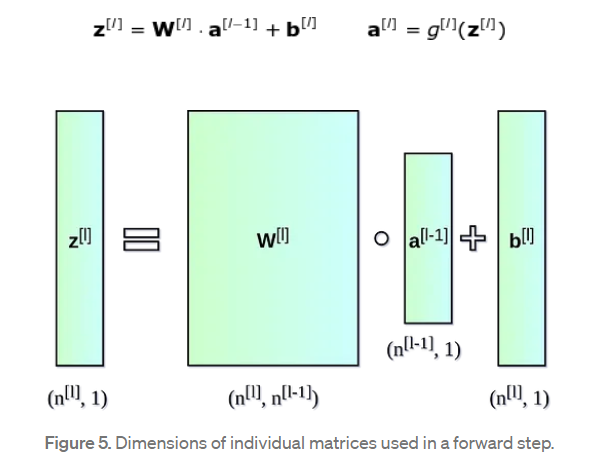

In [506]:
# 1 layer 전진
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    elif activation == 'linear':
        activation_func = linear
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

In [507]:
# 예시 input을 넣었을 때 첫번째 hidden layer의 출력값
single_layer_forward_propagation(X, params_values['W1'],params_values['b1'], activation='relu')

(array([[0.        , 0.        , 0.02169951, ..., 0.02022746, 0.01619394,
         0.0092909 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.1612555 , 0.17596889, 0.21674862, ..., 0.21482914, 0.20956965,
         0.20056845],
        [0.08458384, 0.11918216, 0.21507508, ..., 0.21056144, 0.19819384,
         0.17702765]]),
 array([[-0.02085832, -0.00957457,  0.02169951, ...,  0.02022746,
          0.01619394,  0.0092909 ],
        [-0.02412546, -0.02726638, -0.03597177, ..., -0.03556201,
         -0.03443925, -0.03251773],
        [ 0.1612555 ,  0.17596889,  0.21674862, ...,  0.21482914,
          0.20956965,  0.20056845],
        [ 0.08458384,  0.11918216,  0.21507508, ...,  0.21056144,
          0.19819384,  0.17702765]]))

In [508]:
# 전체 layer 전진
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {} # memory에 각 층의 결과값 저장 (A, Z)
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture): # layer 수 만큼 반복하며 한 층씩 feed forward
        layer_idx = idx + 1 # 층 전진
        A_prev = A_curr 
        
        # A, Z 계산
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # memory에 저장
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

In [509]:
params_values['W1']

array([[ 0.04967142],
       [-0.01382643],
       [ 0.06476885],
       [ 0.15230299]])

In [510]:
A_curr, memory = full_forward_propagation(X,params_values, nn_architecture)
A_curr, memory

(array([[-0.03006013, -0.03005246, -0.03002965, -0.03005378, -0.03005698,
         -0.03004528, -0.03002676, -0.0300537 , -0.03003846, -0.03003512,
         -0.03005385, -0.03003637, -0.03004945, -0.03003995, -0.0300399 ,
         -0.03004355, -0.03005882, -0.03003237, -0.03005104, -0.03005557,
         -0.0300605 , -0.03004149, -0.03003826, -0.03006131, -0.03004444,
         -0.03005422, -0.03003947, -0.03005598, -0.03003776, -0.03004881,
         -0.03002858, -0.03005723, -0.03005036, -0.03005804, -0.03002903,
         -0.0300308 , -0.03005316, -0.03003891, -0.03003304, -0.03004283,
         -0.03004378, -0.03005371, -0.03005873, -0.03003006, -0.03002994,
         -0.03003992, -0.03005042, -0.03005008, -0.03003645, -0.03003006,
         -0.03003044, -0.03003444, -0.03003958, -0.03005903, -0.03005641,
         -0.03003001, -0.03004091, -0.03006156, -0.03005845, -0.03003878,
         -0.0300617 , -0.03005644, -0.03004307, -0.03003772, -0.03003921,
         -0.0300543 , -0.03003697, -0.

# Cost Function
- $\displaystyle\frac{1}{2n}\sum_{i=1}^{n} (y-\hat{y})^2$

- RMSE


In [511]:
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = (1/2*m) * np.power((Y_hat-Y),2)
    return np.squeeze(cost)

def get_RMSE_value(Y_hat, Y):
    n = Y_hat.shape[0]
    return np.power(((1/n)*np.sum(np.power(Y_hat-Y,2))),0.5)

# Back Propagation
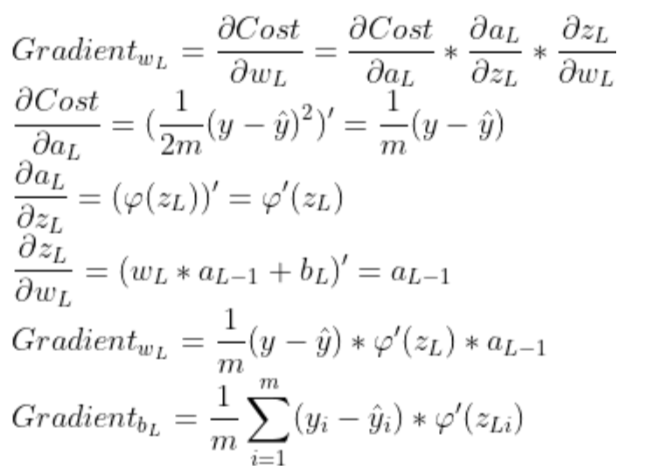

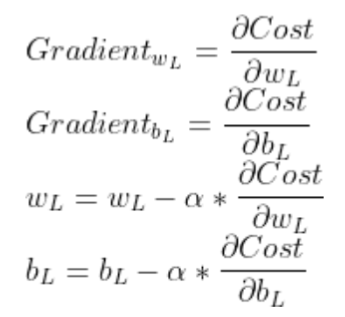

In [512]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation == "linear":
        backward_activation_func = linear_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr) # 결과값(예측값)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

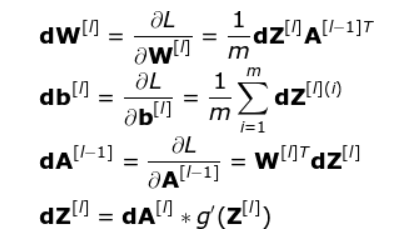

In [513]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {} # gradient 저장
    m = Y.shape[0]
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = (1/m)* (Y-Y_hat)
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))): # 층을 거듭
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev # dA초기화
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [514]:
memory['A4']*0.25

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01071751, 0.01071349, 0.01070209, ..., 0.01070263, 0.01070412,
        0.01070666],
       [0.046548  , 0.04653831, 0.04650944, ..., 0.04651084, 0.04651468,
        0.04652125],
       [0.00358457, 0.00357381, 0.00354412, ..., 0.00354552, 0.00354934,
        0.00355588]])

In [515]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        params_values["W" + str(layer_idx+1)] -= learning_rate * grads_values["dW" + str(layer_idx+1)]        
        params_values["b" + str(layer_idx+1)] -= learning_rate * grads_values["db" + str(layer_idx+1)]

    return params_values

In [516]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture)
    cost_history = []
    RMSE_history = []
    
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X.T, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_RMSE_value(Y_hat, Y)
        RMSE_history.append(accuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, cost_history, RMSE_history

In [517]:
def predict(X, params_values, nn_architecture):
    prediction, _ = full_forward_propagation(X.T, params_values, nn_architecture)
    return prediction

# 모델 TEST

In [526]:
params_values, cost_history, RMSE_history = train(X.T,y,nn_architecture, epochs=1000, learning_rate=0.1)

In [521]:
prediction = predict(X.T, params_values, nn_architecture)

In [525]:
RMSE_history

[478.03420775728995,
 478.0434333000893,
 478.0526592732063,
 478.0618856766576,
 478.07111251046,
 478.0803397746303,
 478.0895674691854,
 478.0987955941423,
 478.1080241495176,
 478.1172531353284,
 478.12648255159127,
 478.1357123983232,
 478.14494267554096,
 478.15417338326165,
 478.1634045215017,
 478.1726360902784,
 478.1818680896082,
 478.19110051950827,
 478.2003333799953,
 478.2095666710861,
 478.21880039279773,
 478.2280345451469,
 478.23726912815044,
 478.2465041418252,
 478.25573958618804,
 478.26497546125586,
 478.27421176704553,
 478.28344850357394,
 478.2926856708578,
 478.30192326891415,
 478.3111612977595,
 478.3203997574113,
 478.3296386478858,
 478.33887796920015,
 478.3481177213713,
 478.3573579044161,
 478.3665985183511,
 478.3758395631936,
 478.38508103895987,
 478.3943229456674,
 478.4035652833328,
 478.412808051973,
 478.4220512516045,
 478.43129488224463,
 478.44053894391016,
 478.4497834366179,
 478.45902836038476,
 478.46827371522716,
 478.47751950116276,
 478

In [523]:
y

array([[1.11558791e-02],
       [8.63167940e-02],
       [8.32030549e-01],
       [6.57600327e-02],
       [2.79692386e-02],
       [2.46365412e-01],
       [9.77692931e-01],
       [6.61179209e-02],
       [4.53352245e-01],
       [5.88873146e-01],
       [6.51900376e-02],
       [5.30591523e-01],
       [1.43522600e-01],
       [4.01099362e-01],
       [4.04711083e-01],
       [2.94489595e-01],
       [9.75984154e-03],
       [7.05909929e-01],
       [1.11221192e-01],
       [3.98638321e-02],
       [1.72647089e-03],
       [3.52024852e-01],
       [4.65262734e-01],
       [1.00870178e-02],
       [2.68557436e-01],
       [5.38983720e-02],
       [4.22587987e-01],
       [3.58035054e-02],
       [4.85193412e-01],
       [1.50634034e-01],
       [8.85073351e-01],
       [2.43246759e-02],
       [1.25956176e-01],
       [1.62949617e-02],
       [8.61384507e-01],
       [7.79044622e-01],
       [6.75589806e-02],
       [4.44951226e-01],
       [6.74730982e-01],
       [3.08926312e-01],


In [522]:
prediction

array([[-0.04218358, -0.04217582, -0.04215274, -0.04217715, -0.04218039,
        -0.04216855, -0.04214982, -0.04217707, -0.04216165, -0.04215828,
        -0.04217722, -0.04215954, -0.04217277, -0.04216316, -0.04216311,
        -0.0421668 , -0.04218225, -0.04215549, -0.04217438, -0.04217897,
        -0.04218394, -0.04216472, -0.04216145, -0.04218477, -0.0421677 ,
        -0.0421776 , -0.04216267, -0.04217938, -0.04216094, -0.04217213,
        -0.04215166, -0.04218064, -0.04217369, -0.04218146, -0.04215212,
        -0.04215391, -0.04217653, -0.04216211, -0.04215618, -0.04216607,
        -0.04216704, -0.04217708, -0.04218216, -0.04215316, -0.04215303,
        -0.04216313, -0.04217376, -0.04217341, -0.04215962, -0.04215316,
        -0.04215354, -0.04215759, -0.04216279, -0.04218246, -0.04217982,
        -0.04215311, -0.04216414, -0.04218502, -0.04218187, -0.04216198,
        -0.04218516, -0.04217984, -0.04216631, -0.04216091, -0.04216242,
        -0.04217768, -0.04216014, -0.04217723, -0.0